In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.distributions import Categorical

import pdb

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

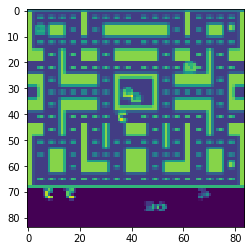

In [2]:
# Create and wrap the environment
env = make_atari('MsPacmanNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [3]:
class soft_DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5, REWARD_SCALE = 1):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(soft_DQN, self).__init__()        
        self.REWARD_SCALE = REWARD_SCALE
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)
    
    def get_action(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        action_probs = F.softmax(self.fc5(x)/self.REWARD_SCALE,-1)
        action_dist = Categorical(action_probs)
        actions = action_dist.sample().view(-1, 1)
        return actions

In [4]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [5]:
class soft_DQNAgent:
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, lr = 1e-4,reward_scale = 1):
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.alpha = reward_scale
        self.DQN = soft_DQN(in_channels = in_channels, num_actions = action_space.n,REWARD_SCALE = reward_scale)
        self.DQN_target = soft_DQN(in_channels = in_channels, num_actions = action_space.n,REWARD_SCALE = reward_scale)
        self.DQN_target.load_state_dict(self.DQN.state_dict())

        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.Adam(self.DQN.parameters(),lr=lr)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, t, explore_time):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if t < explore_time:
            action = self.action_space.sample()
        else:
            # Select a random action (when epsilon probability and q_value are the same in that state)
            action = int(self.DQN.get_action(state).squeeze().cpu().detach().numpy())
        return action
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE
        # compute V*(next_states) using predicted next q-values
        next_state_values =  self.alpha*torch.logsumexp(predicted_next_qvalues/self.alpha, dim = -1) # YOUR CODE        

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma*next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [6]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('MsPacmanNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)
gamma = 0.99
frames = 1000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
update_current_step =4 # update current model every 4 steps

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
reward_scale = 0.5/action_dim
agent = soft_DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate, memory_size = max_buff, reward_scale = reward_scale)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "5_Soft_DQN_MsPacman", comment= "good_makeatari")

for i in range(frames):
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, i, learning_start)
    
    next_frame, reward, is_done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, is_done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        if i % update_current_step == 0:
            loss = agent.learn_from_experience(batch_size)
            losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if is_done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

F:\softwares\ANACONDA\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\softwares\ANACONDA\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, episode:    0
frames:  1000, reward: 240.000000, loss: 0.000000, episode:    1
frames:  2000, reward: 275.000000, loss: 0.000000, episode:    4
frames:  3000, reward: 268.333333, loss: 0.000000, episode:    6
frames:  4000, reward: 257.500000, loss: 0.000000, episode:    8
frames:  5000, reward: 251.000000, loss: 0.000000, episode:   10
frames:  6000, reward: 261.000000, loss: 0.000000, episode:   12
frames:  7000, reward: 232.000000, loss: 0.000000, episode:   15
frames:  8000, reward: 227.000000, loss: 0.000000, episode:   17
frames:  9000, reward: 247.000000, loss: 0.000000, episode:   19
frames: 10000, reward: 248.000000, loss: 0.298832, episode:   21
frames: 11000, reward: 243.000000, loss: 0.591573, episode:   22
frames: 12000, reward: 277.000000, loss: 0.296644, episode:   24
frames: 13000, reward: 286.000000, loss: 0.887927, episode:   26
frames: 14000, reward: 282.000000, loss: 0.007194, episode:   28
frames: 15000, reward: 289.000

frames: 126000, reward: 601.000000, loss: 2.983030, episode:  213
frames: 127000, reward: 544.000000, loss: 1.720016, episode:  215
frames: 128000, reward: 589.000000, loss: 0.888023, episode:  217
frames: 129000, reward: 509.000000, loss: 1.038805, episode:  219
frames: 130000, reward: 570.000000, loss: 0.724817, episode:  221
frames: 131000, reward: 581.000000, loss: 0.885629, episode:  222
frames: 132000, reward: 639.000000, loss: 2.555323, episode:  224
frames: 133000, reward: 710.000000, loss: 2.089181, episode:  225
frames: 134000, reward: 648.000000, loss: 1.377560, episode:  227
frames: 135000, reward: 660.000000, loss: 0.650070, episode:  229
frames: 136000, reward: 654.000000, loss: 0.122130, episode:  231
frames: 137000, reward: 616.000000, loss: 1.389568, episode:  232
frames: 138000, reward: 605.000000, loss: 0.915026, episode:  233
frames: 139000, reward: 788.000000, loss: 0.972409, episode:  235
frames: 140000, reward: 799.000000, loss: 1.126309, episode:  236
frames: 14

frames: 251000, reward: 765.000000, loss: 2.342146, episode:  413
frames: 252000, reward: 723.000000, loss: 1.048869, episode:  415
frames: 253000, reward: 711.000000, loss: 1.444006, episode:  417
frames: 254000, reward: 739.000000, loss: 0.880526, episode:  419
frames: 255000, reward: 624.000000, loss: 0.846001, episode:  421
frames: 256000, reward: 626.000000, loss: 1.512501, episode:  422
frames: 257000, reward: 554.000000, loss: 0.945222, episode:  424
frames: 258000, reward: 628.000000, loss: 5.731346, episode:  425
frames: 259000, reward: 734.000000, loss: 1.764199, episode:  427
frames: 260000, reward: 763.000000, loss: 1.112430, episode:  428
frames: 261000, reward: 763.000000, loss: 0.780095, episode:  430
frames: 262000, reward: 771.000000, loss: 2.364590, episode:  431
frames: 263000, reward: 798.000000, loss: 0.907417, episode:  433
frames: 264000, reward: 734.000000, loss: 1.153023, episode:  435
frames: 265000, reward: 630.000000, loss: 0.571254, episode:  437
frames: 26

frames: 376000, reward: 876.000000, loss: 1.228782, episode:  617
frames: 377000, reward: 891.000000, loss: 0.792024, episode:  618
frames: 378000, reward: 779.000000, loss: 1.133658, episode:  619
frames: 379000, reward: 685.000000, loss: 0.851470, episode:  621
frames: 380000, reward: 693.000000, loss: 6.782870, episode:  622
frames: 381000, reward: 788.000000, loss: 1.810773, episode:  624
frames: 382000, reward: 821.000000, loss: 3.207517, episode:  625
frames: 383000, reward: 904.000000, loss: 2.654013, episode:  626
frames: 384000, reward: 925.000000, loss: 1.801317, episode:  628
frames: 385000, reward: 892.000000, loss: 1.626458, episode:  629
frames: 386000, reward: 862.000000, loss: 2.655841, episode:  631
frames: 387000, reward: 862.000000, loss: 2.237245, episode:  633
frames: 388000, reward: 847.000000, loss: 1.188814, episode:  634
frames: 389000, reward: 753.000000, loss: 1.607710, episode:  636
frames: 390000, reward: 770.000000, loss: 1.529682, episode:  637
frames: 39

frames: 500000, reward: 604.000000, loss: 2.533514, episode:  819
frames: 501000, reward: 637.000000, loss: 4.082534, episode:  821
frames: 502000, reward: 638.000000, loss: 1.743710, episode:  823
frames: 503000, reward: 718.000000, loss: 1.112073, episode:  824
frames: 504000, reward: 766.000000, loss: 6.618478, episode:  825
frames: 505000, reward: 801.000000, loss: 1.926678, episode:  827
frames: 506000, reward: 852.000000, loss: 2.355476, episode:  829
frames: 507000, reward: 871.000000, loss: 7.131805, episode:  830
frames: 508000, reward: 929.000000, loss: 2.642254, episode:  832
frames: 509000, reward: 830.000000, loss: 1.652840, episode:  834
frames: 510000, reward: 830.000000, loss: 2.202082, episode:  834
frames: 511000, reward: 855.000000, loss: 0.988973, episode:  836
frames: 512000, reward: 860.000000, loss: 1.236266, episode:  838
frames: 513000, reward: 936.000000, loss: 1.823673, episode:  839
frames: 514000, reward: 911.000000, loss: 1.170644, episode:  840
frames: 51

frames: 624000, reward: 831.000000, loss: 1.739666, episode: 1009
frames: 625000, reward: 860.000000, loss: 1.569048, episode: 1010
frames: 626000, reward: 878.000000, loss: 1.468045, episode: 1011
frames: 627000, reward: 949.000000, loss: 1.068546, episode: 1013
frames: 628000, reward: 1141.000000, loss: 0.944771, episode: 1014
frames: 629000, reward: 1112.000000, loss: 0.944225, episode: 1016
frames: 630000, reward: 1183.000000, loss: 1.497568, episode: 1017
frames: 631000, reward: 1140.000000, loss: 1.327908, episode: 1019
frames: 632000, reward: 1192.000000, loss: 2.407308, episode: 1020
frames: 633000, reward: 1190.000000, loss: 1.315917, episode: 1021
frames: 634000, reward: 1069.000000, loss: 0.547985, episode: 1023
frames: 635000, reward: 854.000000, loss: 1.247218, episode: 1024
frames: 636000, reward: 936.000000, loss: 13.779946, episode: 1025
frames: 637000, reward: 994.000000, loss: 19.658955, episode: 1027
frames: 638000, reward: 932.000000, loss: 2.743467, episode: 1028
f

frames: 747000, reward: 1107.000000, loss: 1.310608, episode: 1177
frames: 748000, reward: 1178.000000, loss: 1.794841, episode: 1178
frames: 749000, reward: 1182.000000, loss: 2.013047, episode: 1180
frames: 750000, reward: 1254.000000, loss: 1.697894, episode: 1181
frames: 751000, reward: 1160.000000, loss: 1.520822, episode: 1183
frames: 752000, reward: 1217.000000, loss: 2.233574, episode: 1184
frames: 753000, reward: 1246.000000, loss: 7.782510, episode: 1185
frames: 754000, reward: 1380.000000, loss: 2.537025, episode: 1187
frames: 755000, reward: 1529.000000, loss: 1.179562, episode: 1188
frames: 756000, reward: 1502.000000, loss: 2.033170, episode: 1189
frames: 757000, reward: 1538.000000, loss: 1.703759, episode: 1190
frames: 758000, reward: 1533.000000, loss: 1.166536, episode: 1192
frames: 759000, reward: 1582.000000, loss: 9.855608, episode: 1193
frames: 760000, reward: 1724.000000, loss: 2.005602, episode: 1194
frames: 761000, reward: 1716.000000, loss: 2.764449, episode: 

frames: 870000, reward: 1057.000000, loss: 1.275418, episode: 1332
frames: 871000, reward: 1117.000000, loss: 2.575221, episode: 1333
frames: 872000, reward: 1135.000000, loss: 2.311191, episode: 1334
frames: 873000, reward: 1095.000000, loss: 4.619064, episode: 1336
frames: 874000, reward: 1113.000000, loss: 1.408594, episode: 1337
frames: 875000, reward: 1118.000000, loss: 1.686851, episode: 1339
frames: 876000, reward: 1247.000000, loss: 1.873645, episode: 1340
frames: 877000, reward: 1238.000000, loss: 0.865884, episode: 1341
frames: 878000, reward: 1326.000000, loss: 1.173363, episode: 1342
frames: 879000, reward: 1337.000000, loss: 10.202902, episode: 1343
frames: 880000, reward: 1318.000000, loss: 2.184583, episode: 1345
frames: 881000, reward: 1325.000000, loss: 2.302644, episode: 1346
frames: 882000, reward: 1393.000000, loss: 8.378889, episode: 1348
frames: 883000, reward: 1398.000000, loss: 5.522879, episode: 1349
frames: 884000, reward: 1358.000000, loss: 1.298627, episode:

frames: 993000, reward: 1133.000000, loss: 1.097954, episode: 1501
frames: 994000, reward: 1216.000000, loss: 1.649974, episode: 1502
frames: 995000, reward: 1345.000000, loss: 0.607467, episode: 1503
frames: 996000, reward: 1355.000000, loss: 2.169124, episode: 1504
frames: 997000, reward: 1383.000000, loss: 1.840783, episode: 1505
frames: 998000, reward: 1338.000000, loss: 0.933786, episode: 1507
frames: 999000, reward: 1249.000000, loss: 1.451521, episode: 1508


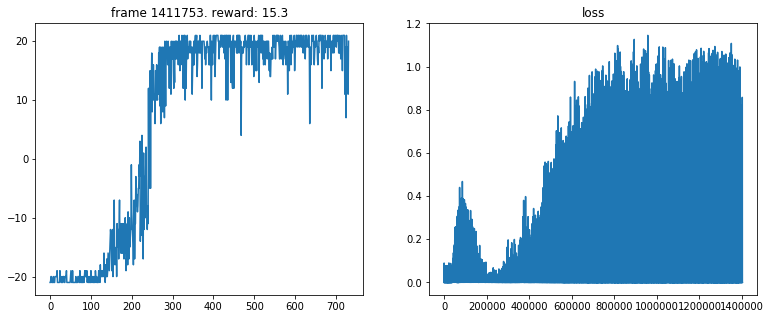

In [9]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)

In [10]:
action_dim

6